In [2]:
import math
import graphviz
import math
import copy
import sys
import arff
import pprint

pp = pprint.PrettyPrinter(depth = 6)

------
### Algorytm K2
<img src="img/K2.png" style="height: 350px">

In [62]:
class K2Algorithm(object):
    def __init__(self, attributes, test_data, scoring_method, max_number_of_parents):
        self.test_data = test_data
        self.scoring_method = scoring_method
        self.attributes = attributes
        self.max_number_of_parents = max_number_of_parents
        
    def new_find_optimal_net(self):
        optimal_net = []
        
        for i, attribute in enumerate(self.attributes):
            parents_of_node_indexes = []
            find_more = True
        
            old_score = self.compute_metric([{'r': attribute['states'], 'name': attribute['name'], 'parents': []}])

            while (find_more and len(parents_of_node_indexes) < self.max_number_of_parents):
                max_new_parent_score, max_new_parent_index = self.find_node_with_max_score(i, attribute, parents_of_node_indexes)
                
                if (max_new_parent_score > old_score):
                    old_score = max_new_parent_score
                    parents_of_node_indexes.append(max_new_parent_index)
                else:
                    find_more = False
                    
            optimal_net.append({'r': attribute['states'], 'name': attribute['name'], 'parents': self.convert_array_of_indexes_to_parents(parents_of_node_indexes)})
                          
        return optimal_net
    
    def find_node_with_max_score(self, index, attribute, parent_indexes):
        current_parents = []
        for current_parent_index in parent_indexes:
            current_parents.append(self.convert_index_to_parent(current_parent_index))
        temp_net = [{'name': attribute['name'], 'r': attribute['states'], 'parents': current_parents}]
        
        parent_index_with_max_score = -1
        max_score = self.compute_metric(temp_net)
        
        for parent_index in range(0, index):
            if parent_index not in parent_indexes:
                temp_net_copy = copy.deepcopy(temp_net)
                temp_net_copy[0]['parents'].append(self.convert_index_to_parent(parent_index))
                parent_candidate_score = self.compute_metric(temp_net_copy)
                
                if (parent_candidate_score > max_score):
                    max_score = parent_candidate_score
                    parent_index_with_max_score = parent_index
                
        return (max_score, parent_index_with_max_score)
    
    def convert_index_to_parent(self, index):
        return {'name': self.attributes[index]['name'], 'q': self.attributes[index]['states']}
    
    def convert_array_of_indexes_to_parents(self, indexes):
        parents = []
        for index in indexes:
            parents.append(self.convert_index_to_parent(index))
        return parents
    
    def compute_metric(self, net):
        if self.scoring_method == 'aic':
            return AICMetric().compute_aic_metric(net, self.test_data)
        elif self.scoring_method == 'mdl':
            return MDLMetric().compute_mdl_metric(net, self.test_data)
        elif self.scoring_method == 'bayes':
            return BayesianMetric(net, self.test_data).compute_bayesian_metric()
        
        raise ValueError(self.scoring_method + " is not a valid scoring method!")

------
### Metryka AIC 
<img src="img/qaic.png"><br/>
<img src="img/k.png">

In [4]:
class AICMetric(object):
    def compute_aic_metric(self, Bs, D):
        return EntropyMetric(Bs, D).compute_entropy_metric() + self.compute_k_factor(Bs)
    
    def compute_k_factor(self, network):
        k_factor = 0
        for node in network:
            k_factor += (len(node['r']) - 1) * self.count_number_of_parent_states(node)
        return k_factor
    
    def count_number_of_parent_states(self, node):
        counter = 0
        for parent in node['parents']:
            counter += len(parent['q'])
        return counter

------
### Metryka MDL (Minimum Description Length)
<img src="img/mdl.png" style="height: 70px"> <br/>
<img src="img/k.png">

In [5]:
class MDLMetric(object):
    def compute_mdl_metric(self, network, test_data):
        return EntropyMetric(network, test_data).compute_entropy_metric() + (self.compute_k_factor(network) / 2) * math.log10(len(test_data))
    
    def compute_k_factor(self, network):
        k_factor = 0
        for node in network:
             k_factor += (len(node['r']) - 1) * self.count_number_of_parent_states(node)
        return k_factor
    
    def count_number_of_parent_states(self, node):
        counter = 0
        for parent in node['parents']:
            counter += len(parent['q'])
        return counter

------
### Metryka bayesowska
<img src="img/bayes-k2.png" style="height: 100px">

In [61]:
class BayesianMetric(object):
    def __init__(self, network, test_data):
        self.network = network
        self.test_data = test_data
        
    def compute_bayesian_metric(self):
        result = 1
        
        for node in self.network:
            r = len(node['r'])
            for parent in node['parents']:
                for parent_state in parent['q']:
                    N_i_j = self.compute_N_i_j(node['name'], node['r'], parent_state, parent['name'])
                    
                    result *= math.factorial(r - 1) / (math.factorial(r - 1 + N_i_j))
                    
                    for node_state in node['r']:
                        result *= math.factorial(self.check_occurences(node['name'], parent['name'], node_state, parent_state))
        
        return result
    
    def compute_N_i_j(self, node_name, node_states, parent_state, parent_name):
        N_i_j = 0
        for node_state in node_states:
            N_i_j += self.check_occurences(node_name, parent_name, node_state, parent_state)
        return N_i_j
    
    def check_occurences(self, node_name, parent_name, node_state, parent_state):
        result = 0
        for single_test_data in self.test_data:
            if single_test_data[node_name] == node_state and single_test_data[parent_name] == parent_state:
                result += 1
        return result
        

------
### Entropia
<img src="img/entropy.png" style="height: 100px">

In [6]:
class EntropyMetric(object):
    def __init__(self, network, test_data):
        self.network = network
        self.test_data = test_data
    
    def compute_entropy_metric(self):
        result = 0
        
        for node in self.network:
            if not node['parents']: # Brak rodzica
                result += self.compute_metric_for_node_without_parent(node)
                continue
                
            for node_state in node['r']:
                for parent in node['parents']:
                    for parent_state in parent['q']:
                        N_i_j = self.compute_occurences_for_all_node_states(node, (parent['name'], parent_state))
                        N_i_j_k = self.count_occurences((node['name'], node_state), (parent['name'], parent_state))
                        if (N_i_j_k != 0 and N_i_j != 0):
                            result += self.compute_metric_component(N_i_j, N_i_j_k)
                    
        return -1 * len(self.test_data) * result
    
    def compute_metric_for_node_without_parent(self, node):  
        N_i_j = len(self.test_data)
        N_i_j_k = self.compute_occurences_for_all_node_states_without_parent(node)
        if N_i_j_k == 0:
            N_i_j_k = 1
        
        return self.compute_metric_component(N_i_j, N_i_j_k)
    
    def compute_occurences_for_all_node_states(self, node, parent):
        result = 0
        for state in node['r']:
            result += self.count_occurences((node['name'], state), parent)
        return result
    
    def compute_occurences_for_all_node_states_without_parent(self, node):
        result = 0
        for state in node['r']:
            result += self.count_single_occurences(node['name'], state)
        return result
    
    def count_occurences(self, node, parent):
        counter = 0
        for data in self.test_data:
            if data[node[0]] == node[1] and data[parent[0]] == parent[1]:
                counter += 1 
        return counter
    
    def count_single_occurences(self, name, state):
        counter = 0
        for data in self.test_data:
            if data[name] == state:
                counter += 1 
        return counter
     
    def compute_metric_component(self, N_i_j, N_i_j_k):
        return (N_i_j_k / len(self.test_data)) * math.log10(N_i_j_k / N_i_j)

------

### Ładowanie pliku ARFF

In [69]:
with open('data/vehicle.arff') as fh:
    data = arff.load(fh)
    
    attributes = []
    for i, p in enumerate(data['attributes']):
        attributes.append({'name': p[0], 'states': p[1]})
    
    sample_data = []
    for i, p in enumerate(data['data']):
        temp_dict = {}
        for j, d in enumerate(p):
            temp_dict.update({attributes[j]['name']: d})
        sample_data.append(temp_dict)

------

### Wybór argumentu - klasy

In [72]:
    index_of_class_attribute = 18
    print("Class argument: ")
    pp.pprint(attributes[index_of_class_attribute])
    
    final_attributes = []
    final_attributes.append(attributes[index_of_class_attribute])
    
    for i, p in enumerate(attributes):
        if i != index_of_class_attribute:
            final_attributes.append(p)

Class argument: 
{'name': 'Class', 'states': ['opel', 'saab', 'bus', 'van']}


-----
### Główne wywołanie algorytmu i rysowanie grafu

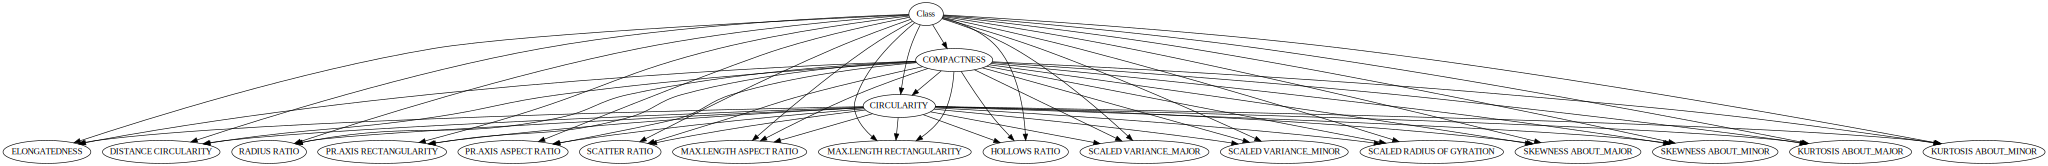

In [76]:
# Metody oceny sieci: 'aic' lub 'mdl'
bayesian_network = K2Algorithm(final_attributes, sample_data, 'mdl', 3).new_find_optimal_net()

graph = graphviz.Digraph('generated graph')        
for node in bayesian_network:
    if not node['parents']:
        graph.node(node['name'] , label = node['name'])
    else:
        for parent in node['parents']:
            graph.edge(parent['name'], node['name'])          
graph

-----
### Klasyfikacja przy dowolnych podanych warunkach
<img src="img/classify.png">

In [68]:
class From(object):
    def __init__(self, bayesian_network, test_data):
        self.bayesian_network = bayesian_network
        self.conditionals = []
        self.test_data = test_data
    
    def given(self, name, value):
        self.conditionals.append({"name": name, "value": value})
        return self
    
    def classify(self, class_attribute_name):
        final_result = []
        for class_state in self.find_class_attribute_states(class_attribute_name):
            result = 1
            temp_conditionals = copy.deepcopy(self.conditionals)
            temp_conditionals.append({"name": class_attribute_name, "value": class_state})
            
            for node in self.bayesian_network:
                tuples = []
                tuples.append((node["name"], self.get_conditional_value(node['name'], temp_conditionals), True))
                    
                for parent in node['parents']:    
                    tuples.append((parent['name'], self.get_conditional_value(parent['name'], temp_conditionals), False))
                    
                result *= self.compute_probability(tuples)
            
            final_result.append({"state": class_state, "value": result})  
                
        return self.normalize_probabilities_sum(final_result)
    
    def normalize_probabilities_sum(self, result_table):
        probabilities_sum = self.compute_probabilities_sum(result_table)
        for result in result_table:
            result['value'] = (result['value'] / probabilities_sum) * 100.0
        return result_table
    
    def compute_probabilities_sum(self, result_table):
        probabilities_sum = 0
        for result in result_table:
            probabilities_sum += result['value']
        return probabilities_sum
            
    def get_conditional_value(self, name, conditionals):
        for conditional in conditionals:
            if conditional["name"] == name:
                return conditional["value"]
        raise ValueError("There's no " + name + " conditional in conditionals")
    
    def find_class_attribute_states(self, class_attribute_name):
        for node in self.bayesian_network:
            if (node['name'] == class_attribute_name):
                return node['r']
            
        raise ValueError(class_attribute_name + " -> No class attribute state error")
    
    def compute_probability(self, tuples):
        all_conditions_counter = self.count_occurences_of_fullfilled_conditions(tuples)
        
        if len(tuples) == 0: 
            return all_conditions_counter / len(self.test_data)

        self.delete_parent_from_tuples(tuples)
        
        parent_conditions_counter = self.count_occurences_of_fullfilled_conditions(tuples)
        
        if all_conditions_counter == 0 or parent_conditions_counter == 0:
            return 1 / self.count_number_of_states(tuples)

        return all_conditions_counter / parent_conditions_counter
    
    def count_occurences_of_fullfilled_conditions(self, tuples):
        counter = 0
        for test_data_line in self.test_data:
            if (self.does_test_line_fullfill_conditions(tuples, test_data_line)):
                counter += 1
        return counter
    
    def does_test_line_fullfill_conditions(self, tuples, test_data_line):
        for condition_tuple in tuples:
            if test_data_line[condition_tuple[0]] != condition_tuple[1]:
                return False
        return True
    
    def count_number_of_states(self, tuples):
        result = 0
        for single_tuple in tuples:
            for node in self.bayesian_network:
                if node['name'] == single_tuple[0]:
                    result += len(node['r'])
        return result
    
    def delete_parent_from_tuples(self, tuples):
        for i, single_tuple in enumerate(tuples):
            if single_tuple[2]:
                del tuples[i]
        return tuples

In [69]:
print("Should be no", From(bayesian_network, sample_data).given('outlook', 'sunny').given('temperature', 'hot').given('humidity', 'high').given('windy', 'FALSE').classify('play'))
print("Should be no", From(bayesian_network, sample_data).given('outlook', 'sunny').given('temperature', 'hot').given('humidity', 'high').given('windy', 'TRUE').classify('play'))
print("Should be yes", From(bayesian_network, sample_data).given('outlook', 'overcast').given('temperature', 'hot').given('humidity', 'high').given('windy', 'FALSE').classify('play'))
print("Should be yes", From(bayesian_network, sample_data).given('outlook', 'rainy').given('temperature', 'mild').given('humidity', 'high').given('windy', 'FALSE').classify('play'))
print("Should be yes", From(bayesian_network, sample_data).given('outlook', 'rainy').given('temperature', 'cool').given('humidity', 'normal').given('windy', 'FALSE').classify('play'))
print("Should be no", From(bayesian_network, sample_data).given('outlook', 'rainy').given('temperature', 'cool').given('humidity', 'normal').given('windy', 'TRUE').classify('play'))
print("Should be yes", From(bayesian_network, sample_data).given('outlook', 'overcast').given('temperature', 'cool').given('humidity', 'normal').given('windy', 'TRUE').classify('play'))
print("Should be no", From(bayesian_network, sample_data).given('outlook', 'sunny').given('temperature', 'mild').given('humidity', 'high').given('windy', 'FALSE').classify('play'))
print("Should be yes", From(bayesian_network, sample_data).given('outlook', 'sunny').given('temperature', 'cool').given('humidity', 'normal').given('windy', 'FALSE').classify('play'))
print("Should be yes", From(bayesian_network, sample_data).given('outlook', 'rainy').given('temperature', 'mild').given('humidity', 'normal').given('windy', 'FALSE').classify('play'))
print("Should be yes", From(bayesian_network, sample_data).given('outlook', 'sunny').given('temperature', 'mild').given('humidity', 'normal').given('windy', 'TRUE').classify('play'))
print("Should be yes", From(bayesian_network, sample_data).given('outlook', 'overcast').given('temperature', 'mild').given('humidity', 'high').given('windy', 'TRUE').classify('play'))
print("Should be yes", From(bayesian_network, sample_data).given('outlook', 'overcast').given('temperature', 'hot').given('humidity', 'normal').given('windy', 'FALSE').classify('play'))
print("Should be no", From(bayesian_network, sample_data).given('outlook', 'rainy').given('temperature', 'mild').given('humidity', 'high').given('windy', 'TRUE').classify('play'))

Should be no [{'state': 'yes', 'value': 40.0}, {'state': 'no', 'value': 60.0}]
Should be no [{'state': 'yes', 'value': 40.0}, {'state': 'no', 'value': 60.00000000000001}]
Should be yes [{'state': 'yes', 'value': 61.53846153846153}, {'state': 'no', 'value': 38.46153846153847}]
Should be yes [{'state': 'yes', 'value': 60.0}, {'state': 'no', 'value': 40.00000000000001}]
Should be yes [{'state': 'yes', 'value': 60.0}, {'state': 'no', 'value': 40.00000000000001}]
Should be no [{'state': 'yes', 'value': 59.999999999999986}, {'state': 'no', 'value': 40.0}]
Should be yes [{'state': 'yes', 'value': 61.53846153846153}, {'state': 'no', 'value': 38.46153846153847}]
Should be no [{'state': 'yes', 'value': 40.0}, {'state': 'no', 'value': 60.0}]
Should be yes [{'state': 'yes', 'value': 40.0}, {'state': 'no', 'value': 60.00000000000001}]
Should be yes [{'state': 'yes', 'value': 60.0}, {'state': 'no', 'value': 40.0}]
Should be yes [{'state': 'yes', 'value': 40.0}, {'state': 'no', 'value': 60.0}]
Should

In [85]:
print("Should be republican", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "y").given("synfuels-corporation-cutback", "?").given("education-spending", "y").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "n").given("export-administration-act-south-africa", "y").classify("Class"))
print("Should be republican", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "n").given("education-spending", "y").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "n").given("export-administration-act-south-africa", "?").classify("Class"))
print("Should be democrat", From(bayesian_network, sample_data).given("handicapped-infants", "?").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "y").given("physician-fee-freeze", "?").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "y").given("education-spending", "n").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "n").given("export-administration-act-south-africa", "n").classify("Class"))
print("Should be democrat", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "y").given("physician-fee-freeze", "n").given("el-salvador-aid", "?").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "y").given("education-spending", "n").given("superfund-right-to-sue", "y").given("crime", "n").given("duty-free-exports", "n").given("export-administration-act-south-africa", "y").classify("Class"))
print("Should be democrat", From(bayesian_network, sample_data).given("handicapped-infants", "y").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "y").given("physician-fee-freeze", "n").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "y").given("education-spending", "?").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "y").given("export-administration-act-south-africa", "y").classify("Class"))
print("Should be democrat", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "y").given("physician-fee-freeze", "n").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "n").given("education-spending", "n").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "y").given("export-administration-act-south-africa", "y").classify("Class"))
print("Should be democrat", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "n").given("education-spending", "n").given("superfund-right-to-sue", "?").given("crime", "y").given("duty-free-exports", "y").given("export-administration-act-south-africa", "y").classify("Class"))
print("Should be republican", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "n").given("education-spending", "n").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "?").given("export-administration-act-south-africa", "y").classify("Class"))
print("Should be republican", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "n").given("education-spending", "y").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "n").given("export-administration-act-south-africa", "y").classify("Class"))
print("Should be democrat", From(bayesian_network, sample_data).given("handicapped-infants", "y").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "y").given("physician-fee-freeze", "n").given("el-salvador-aid", "n").given("religious-groups-in-schools", "n").given("anti-satellite-test-ban", "y").given("aid-to-nicaraguan-contras", "y").given("mx-missile", "y").given("immigration", "n").given("synfuels-corporation-cutback", "n").given("education-spending", "n").given("superfund-right-to-sue", "n").given("crime", "n").given("duty-free-exports", "?").given("export-administration-act-south-africa", "?").classify("Class"))
print("Should be republican", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "n").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "?").given("education-spending", "?").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "n").given("export-administration-act-south-africa", "n").classify("Class"))
print("Should be republican", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "y").given("education-spending", "?").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "?").given("export-administration-act-south-africa", "?").classify("Class"))
print("Should be democrat", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "y").given("physician-fee-freeze", "n").given("el-salvador-aid", "n").given("religious-groups-in-schools", "n").given("anti-satellite-test-ban", "y").given("aid-to-nicaraguan-contras", "y").given("mx-missile", "y").given("immigration", "n").given("synfuels-corporation-cutback", "n").given("education-spending", "n").given("superfund-right-to-sue", "y").given("crime", "n").given("duty-free-exports", "?").given("export-administration-act-south-africa", "?").classify("Class"))
print("Should be democrat", From(bayesian_network, sample_data).given("handicapped-infants", "y").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "y").given("physician-fee-freeze", "n").given("el-salvador-aid", "n").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "y").given("aid-to-nicaraguan-contras", "y").given("mx-missile", "?").given("immigration", "y").given("synfuels-corporation-cutback", "y").given("education-spending", "?").given("superfund-right-to-sue", "n").given("crime", "n").given("duty-free-exports", "y").given("export-administration-act-south-africa", "?").classify("Class"))
print("Should be republican", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "n").given("synfuels-corporation-cutback", "n").given("education-spending", "y").given("superfund-right-to-sue", "?").given("crime", "?").given("duty-free-exports", "n").given("export-administration-act-south-africa", "?").classify("Class"))
print("Should be republican", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "y").given("synfuels-corporation-cutback", "n").given("education-spending", "y").given("superfund-right-to-sue", "y").given("crime", "?").given("duty-free-exports", "n").given("export-administration-act-south-africa", "?").classify("Class"))
print("Should be republican", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "n").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "?").given("aid-to-nicaraguan-contras", "?").given("mx-missile", "?").given("immigration", "?").given("synfuels-corporation-cutback", "n").given("education-spending", "y").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "n").given("export-administration-act-south-africa", "y").classify("Class"))
print("Should be republican", From(bayesian_network, sample_data).given("handicapped-infants", "n").given("water-project-cost-sharing", "y").given("adoption-of-the-budget-resolution", "n").given("physician-fee-freeze", "y").given("el-salvador-aid", "y").given("religious-groups-in-schools", "y").given("anti-satellite-test-ban", "n").given("aid-to-nicaraguan-contras", "n").given("mx-missile", "n").given("immigration", "y").given("synfuels-corporation-cutback", "n").given("education-spending", "y").given("superfund-right-to-sue", "y").given("crime", "y").given("duty-free-exports", "?").given("export-administration-act-south-africa", "n").classify("Class"))

Should be republican [{'state': 'democrat', 'value': 34.032532016213906}, {'state': 'republican', 'value': 65.9674679837861}]
Should be republican [{'state': 'democrat', 'value': 51.983497036587146}, {'state': 'republican', 'value': 48.016502963412854}]
Should be democrat [{'state': 'democrat', 'value': 77.83474065138721}, {'state': 'republican', 'value': 22.165259348612782}]
Should be democrat [{'state': 'democrat', 'value': 63.271476848283626}, {'state': 'republican', 'value': 36.728523151716374}]
Should be democrat [{'state': 'democrat', 'value': 90.86161879895562}, {'state': 'republican', 'value': 9.138381201044385}]
Should be democrat [{'state': 'democrat', 'value': 63.271476848283626}, {'state': 'republican', 'value': 36.72852315171637}]
Should be democrat [{'state': 'democrat', 'value': 51.983497036587146}, {'state': 'republican', 'value': 48.01650296341286}]
Should be republican [{'state': 'democrat', 'value': 51.983497036587146}, {'state': 'republican', 'value': 48.01650296341